In [32]:
import copy
import os
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter,filtfilt
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import pickle
import control as ct
import cvxpy as cp
import seaborn as sns
import pandas as pd
from scipy.io import loadmat,savemat

In [33]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        # Decide if we want to enforce that the models have eigenvalues that come in complex conjugate pairs, and 
        # enforce stability
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

In [34]:
def make_graph(data,title,legend,impulse,time): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot



    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if impulse == False:
        plt.xlim([0,4])


    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k','--g']
    alphas = [1,.65,1]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)
    


In [35]:
def load_vacuum_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
    state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time




## Complex conjugate and stable does the best

In [36]:
def load_plasma_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                                 #One important change is that for a plasma shot we will look at the voltage, not the flux circuits
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4','i_tor']
    state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))



    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list




In [37]:
directory = "data/vacuum_shots_220816/good_shots"
trajectory_list,inputs_list,state_deriv_list,experiment_time = load_vacuum_shot(directory)

object successfully saved to data/continuous_vacuum_ss_model
(13, 13)
(4, 4)


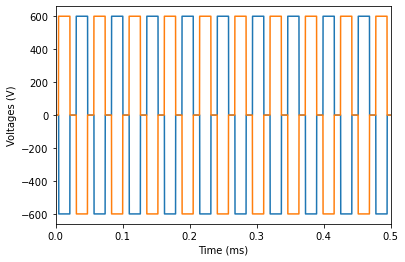

In [38]:
filename = 'data/continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

A_plasma = loadmat('data/plasma_ss_A_matrix_test').get('A')

print(np.shape(A_plasma))

B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

print(np.shape(D))

data = loadmat('data/voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift1']
voltage3 = data['newVoltageShift2']
voltage4 = data['newVoltageShift3']
time = np.linspace(0,.004,len(voltage1))

plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()


In [39]:
print(np.linalg.eigvals(A_plasma))

[ -5365.24185942+128311.09214227j  -5365.24185942-128311.09214227j
  -6164.51182327+138653.06449622j  -6164.51182327-138653.06449622j
 -12217.769524       +0.j          -6044.96266362+137273.04653401j
  -6044.96266362-137273.04653401j  -6044.96266362+137273.04653401j
  -6044.96266362-137273.04653401j  -1983.16938827     +0.j
  -3043.64370228     +0.j          -2915.80449147     +0.j
  -2915.80449147     +0.j        ]


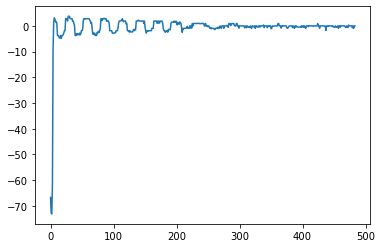

In [40]:
inputs = np.hstack((voltage1,voltage2,voltage3,voltage4))

#we want 1 millisecond of ringdown where the SPA isn't firing, so I'm going to make the last quarter of the voltage waveforms 0

inputs[30000::,:] = 0

plt.plot(inputs_list[2][1772::,0])

(40001, 12)


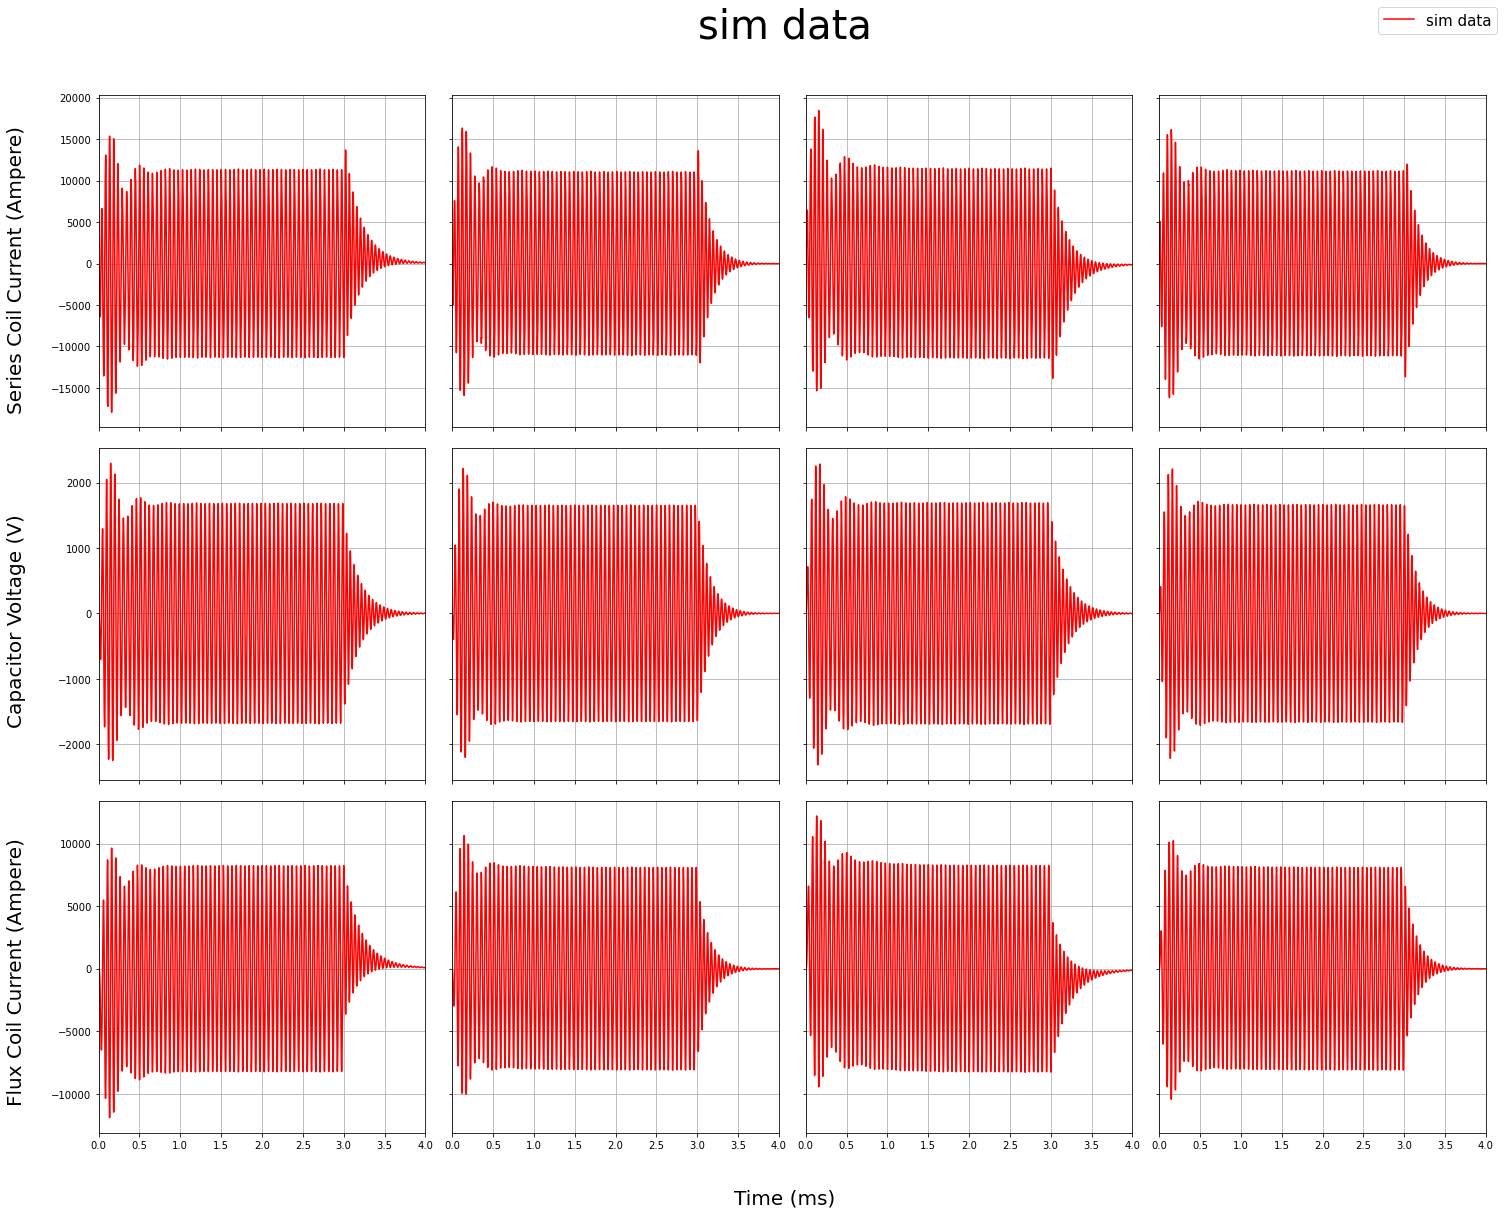

In [48]:
tout,yout,xout_vacuum = lsim((A,B,C,D),inputs,time)
print(np.shape(xout_vacuum))
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(xout_vacuum[30000::,i])
make_graph([xout_vacuum],'sim data',['sim data'],impulse =False ,time = time)

## BOP-DMD on clean simulated data

In [49]:
# print(np.linalg.eigvals(Atilde_vacuum_list[4]).real)




In [50]:
Atilde_vacuum_list = []
bop_vacuum_obj_list = []
xout_vacuum_list = []
for i in range(0,12):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 10,
        training_set = xout_vacuum.real[30000::,:].T, #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = inputs[30000::,:],
        test_voltage = inputs,
        train_time = time[30000::],
        test_time = time, #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,#np.vstack((B,np.zeros((1,4)))),
        C = C,#np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_vacuum_list.append(Atilde)
    bop_vacuum_obj_list.append(bop_obj)
    xout_vacuum_list.append(xout)

In [30]:
# u,s,vt = np.linalg.svd(xout[1521::,:].real,full_matrices = False)


# optdmd = BOPDMD(svd_rank=12, num_trials=0)
# bopdmd = BOPDMD(svd_rank=5, num_trials=5,compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})

# bopdmd.fit(xout[1521::,:].T,experiment_time[1772::])



In [31]:
# tout,yout,xout_test = lsim((bopdmd.A,B,C,D),inputs_list[2][251::,:],experiment_time[251::])

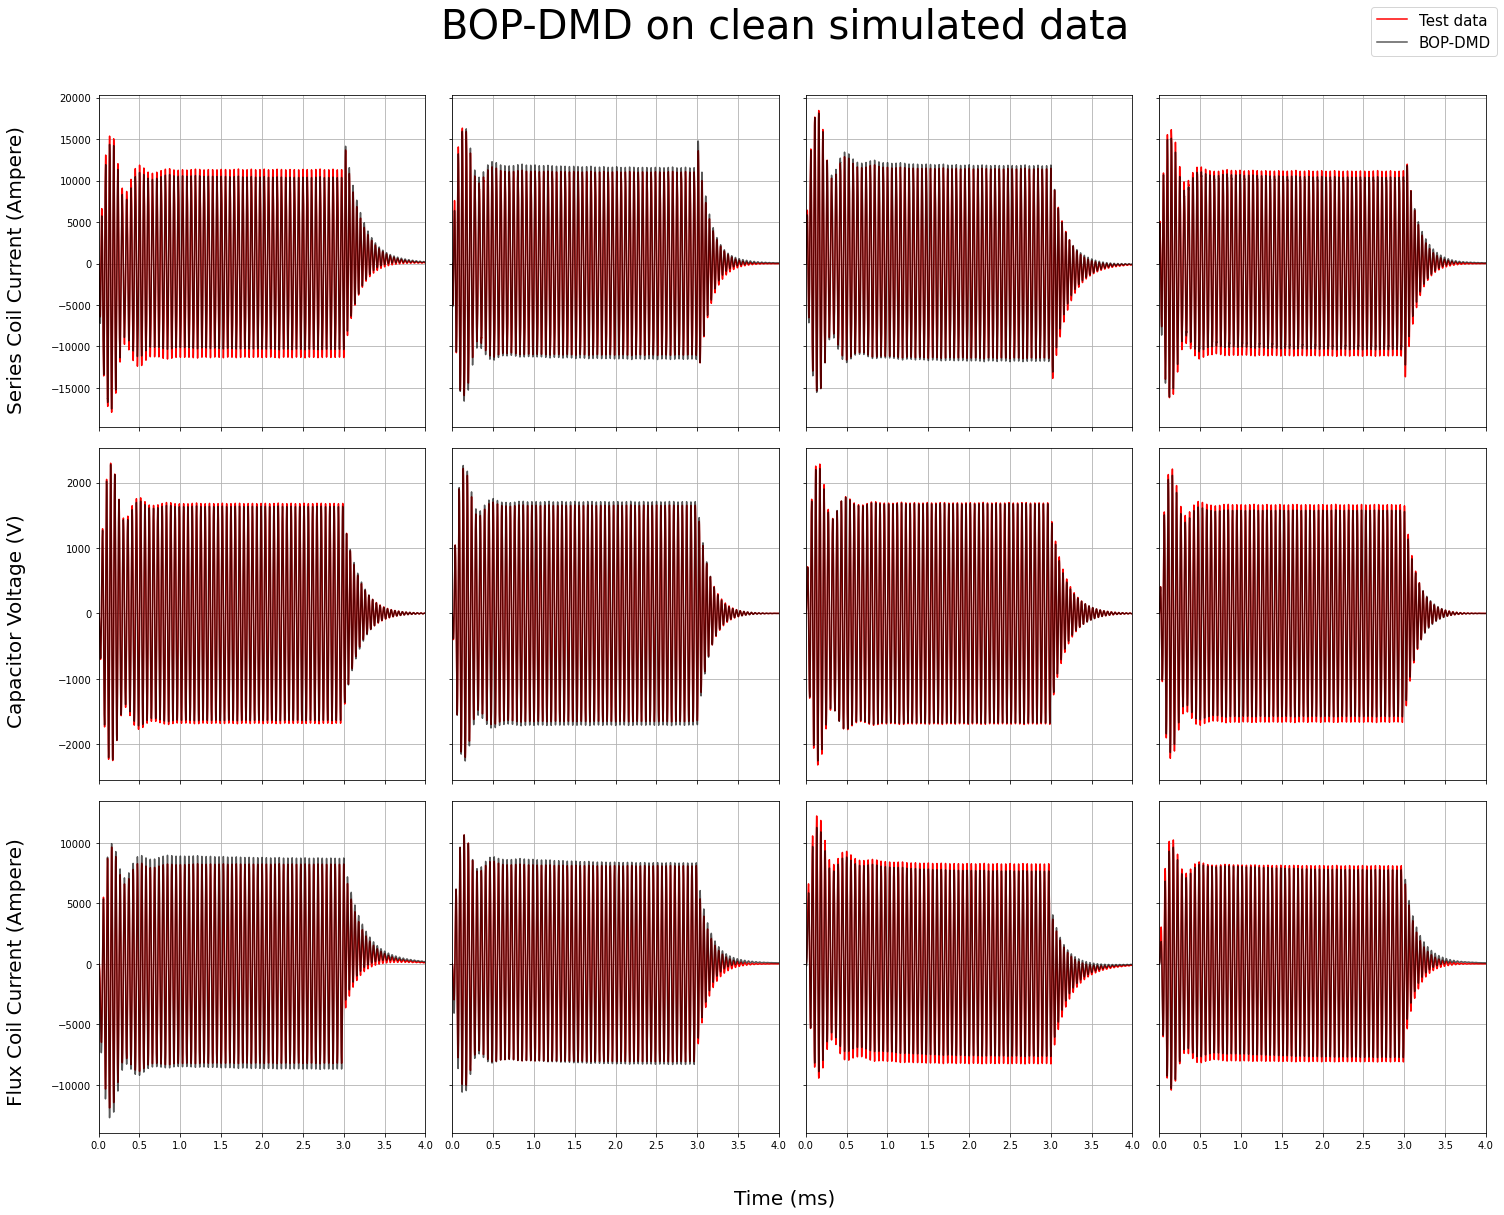

In [51]:
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(xout_test.real[:,i])
#     plt.plot(xout[:,i])
num = 11
make_graph([xout_vacuum,xout_vacuum_list[num]],'BOP-DMD on clean simulated data',['Test data','BOP-DMD'],
           impulse = False,time = time)

## Leave commented out. Saves the A matrix that generated the reconstruction from above

In [36]:
# bop_dict = {'matrix':Atilde_vacuum_list[11],'label': 'BOP'}

# dmd_A = savemat('BOP_A_matrix_sim_data.mat',bop_dict)

tout,yout,xout_vacuum_experiment = lsim((A,B,C,D),inputs_list[2][251::,:],experiment_time[251::])

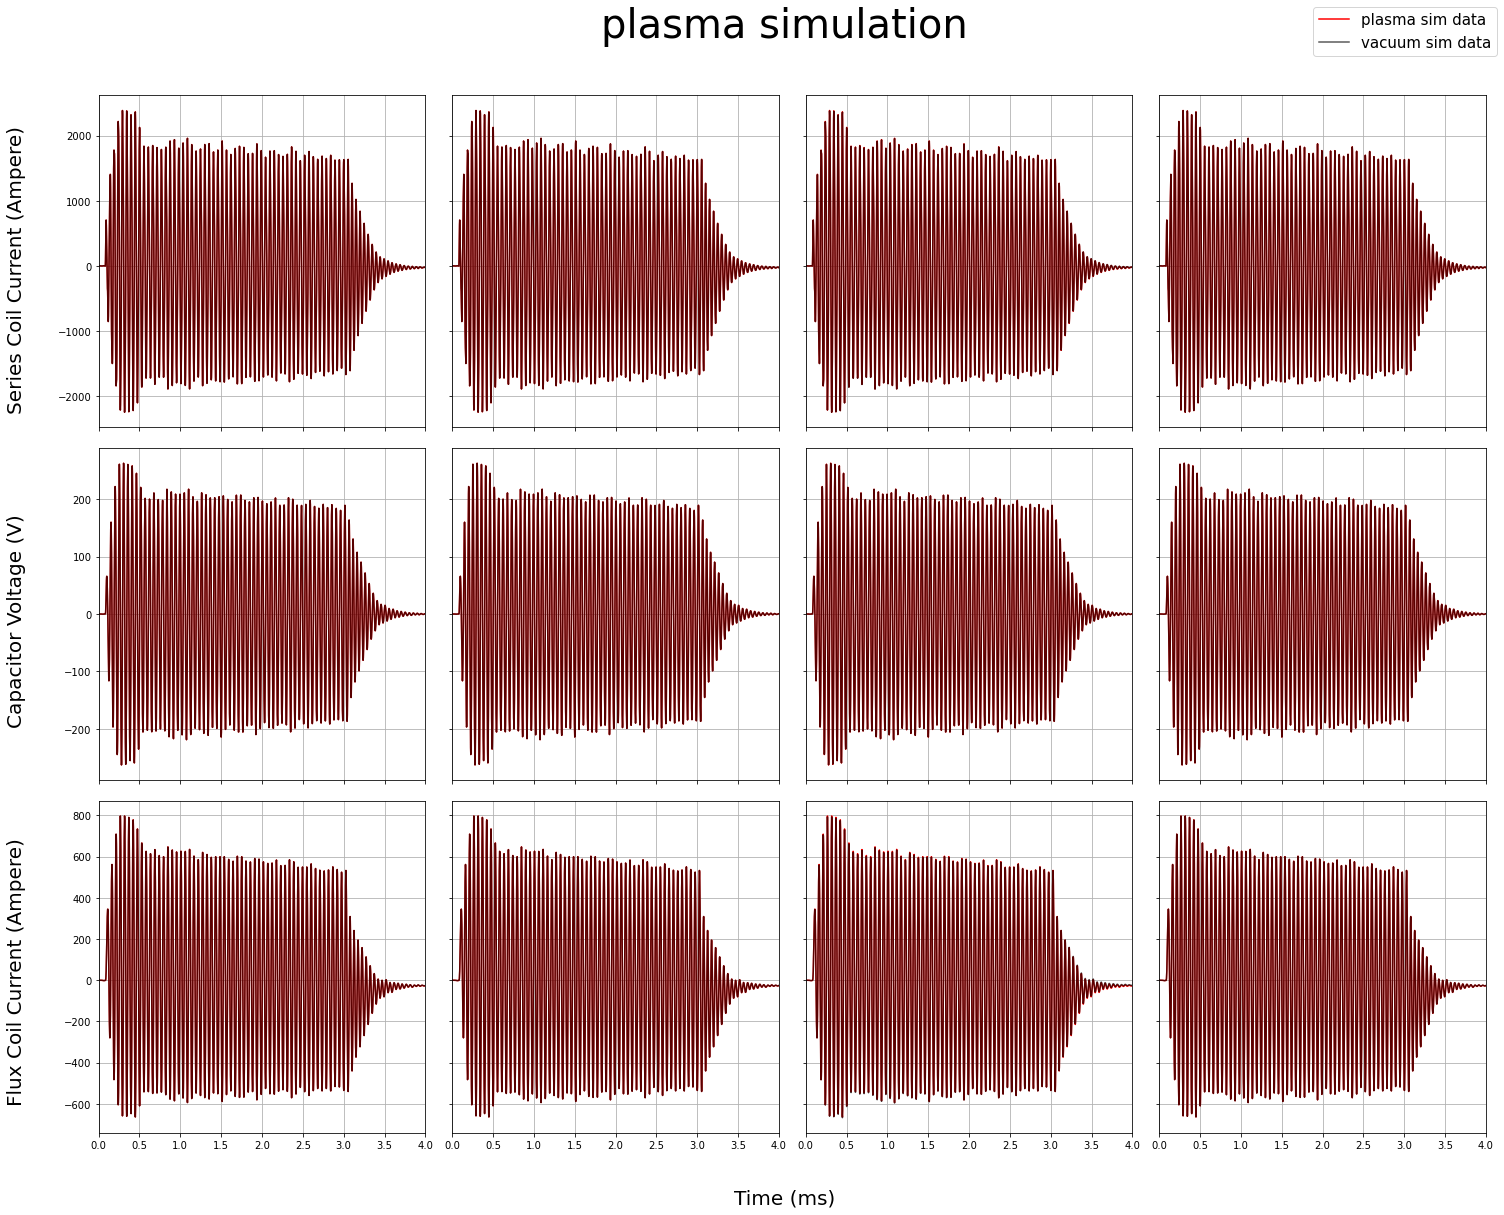

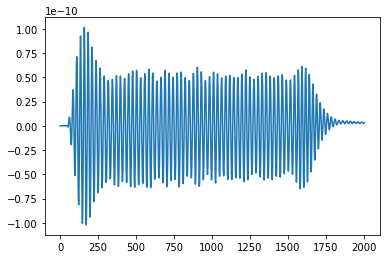

In [72]:
tout,yout,xout_plasma = lsim((A_plasma,B_plasma,C_plasma,D),inputs_list[2][251::,:],experiment_time[251::])

make_graph([xout_plasma,xout_vacuum_experiment],'plasma simulation',['plasma sim data','vacuum sim data'],
           impulse = False,time = experiment_time[251::])

plt.figure()
plt.plot(xout_plasma[:,12])

In [50]:
Atilde_plasma_list = []
bop_plasma_obj_list = []
xout_plasma_list = []
for i in range(13):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 10,
        training_set = xout_plasma[1521::,0:13].T, #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = inputs_list[2][1772::,:],
        test_voltage = inputs_list[2][251::],
        train_time = experiment_time[1772::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = False,
        noise_level = 0,
        evaluate = True)
    Atilde_plasma_list.append(Atilde.real)
    bop_plasma_obj_list.append(bop_obj)
    xout_plasma_list.append(xout.real)

In [51]:
# make_graph([xout_vacuum[30000::,:],xout_plasma[30000::,:]],'Vacuum vs plasma sim',['vacuum','plasma'],
#            impulse = True,time = time[30000::])

13


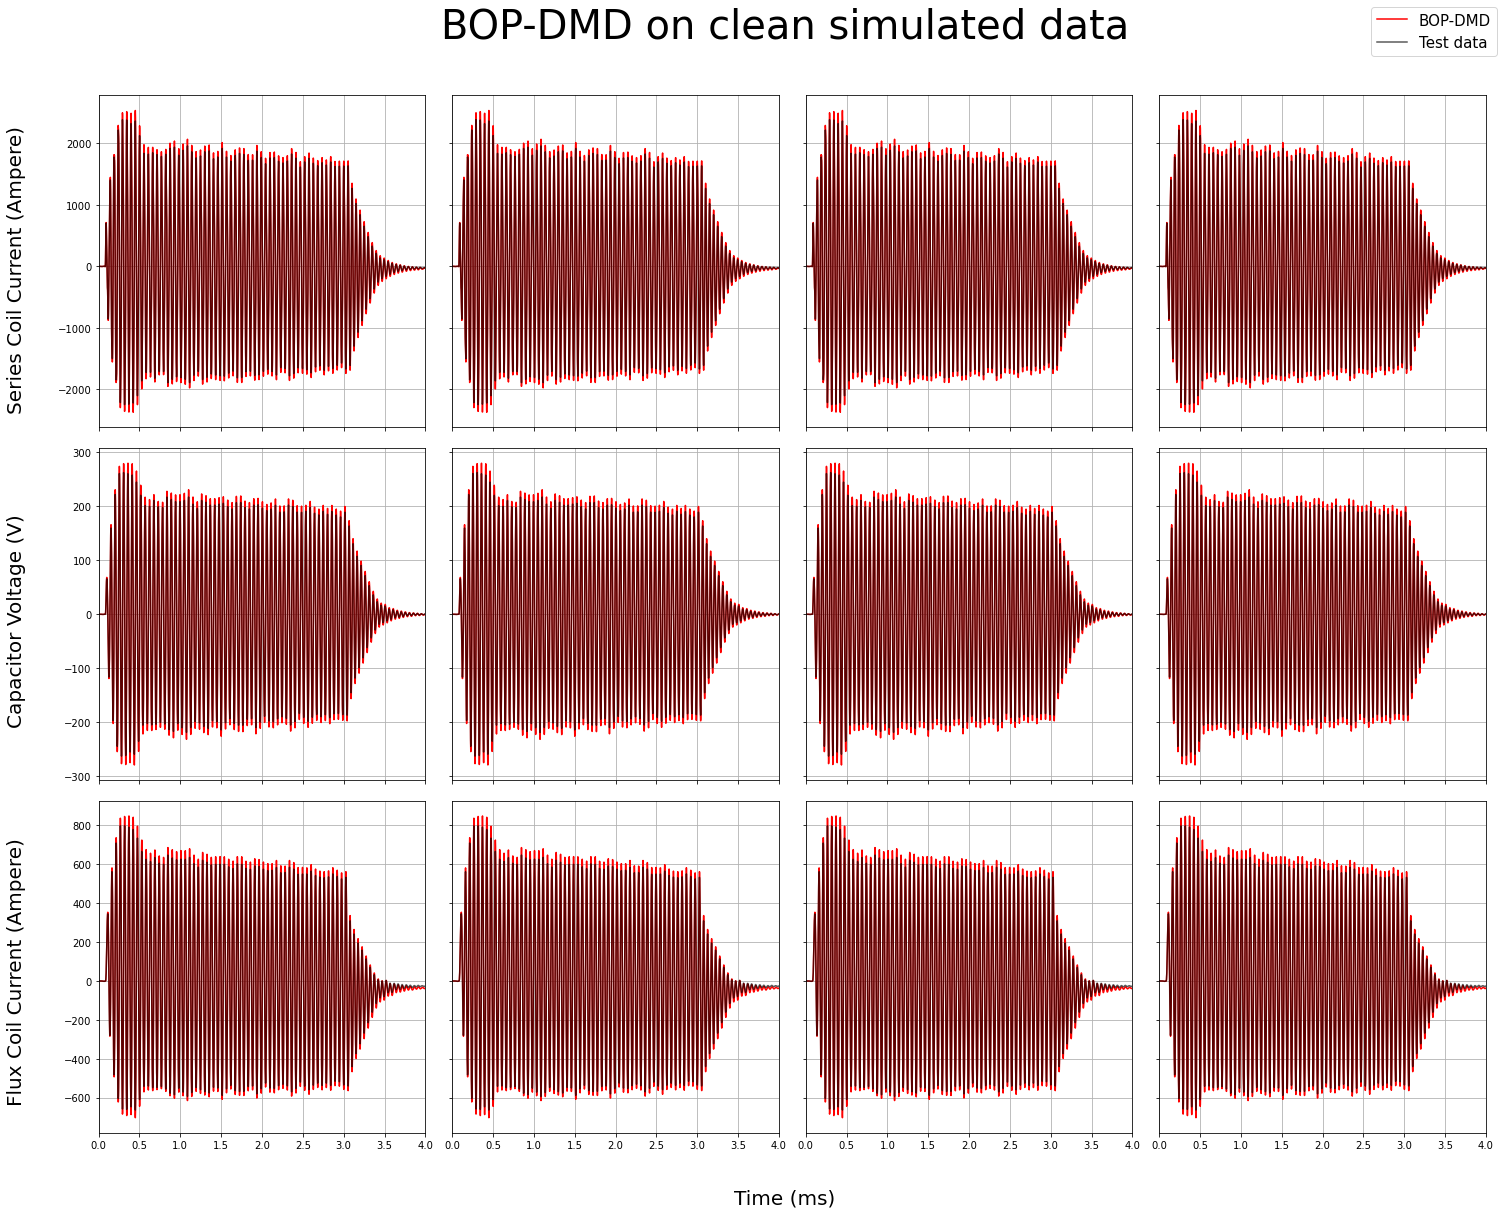

In [58]:
num = 2

print(len(xout_plasma_list))
make_graph([xout_plasma_list[num],xout_plasma],'BOP-DMD on clean simulated data',['BOP-DMD','Test data'],
           impulse = False,time = experiment_time[251::])


2536.3609155744334


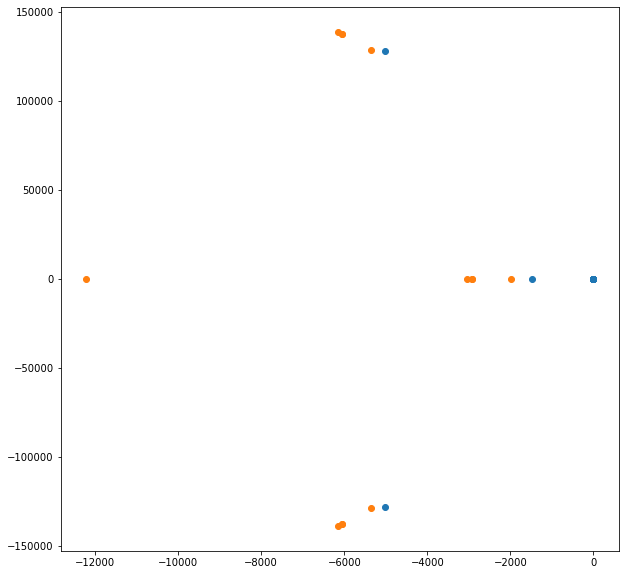

In [55]:
plt.figure(figsize = (10,10))
plt.scatter(np.linalg.eigvals(Atilde_plasma_list[num]).real,np.linalg.eigvals(Atilde_plasma_list[num]).imag)
plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag)
print(np.max(xout_plasma_list[num]))

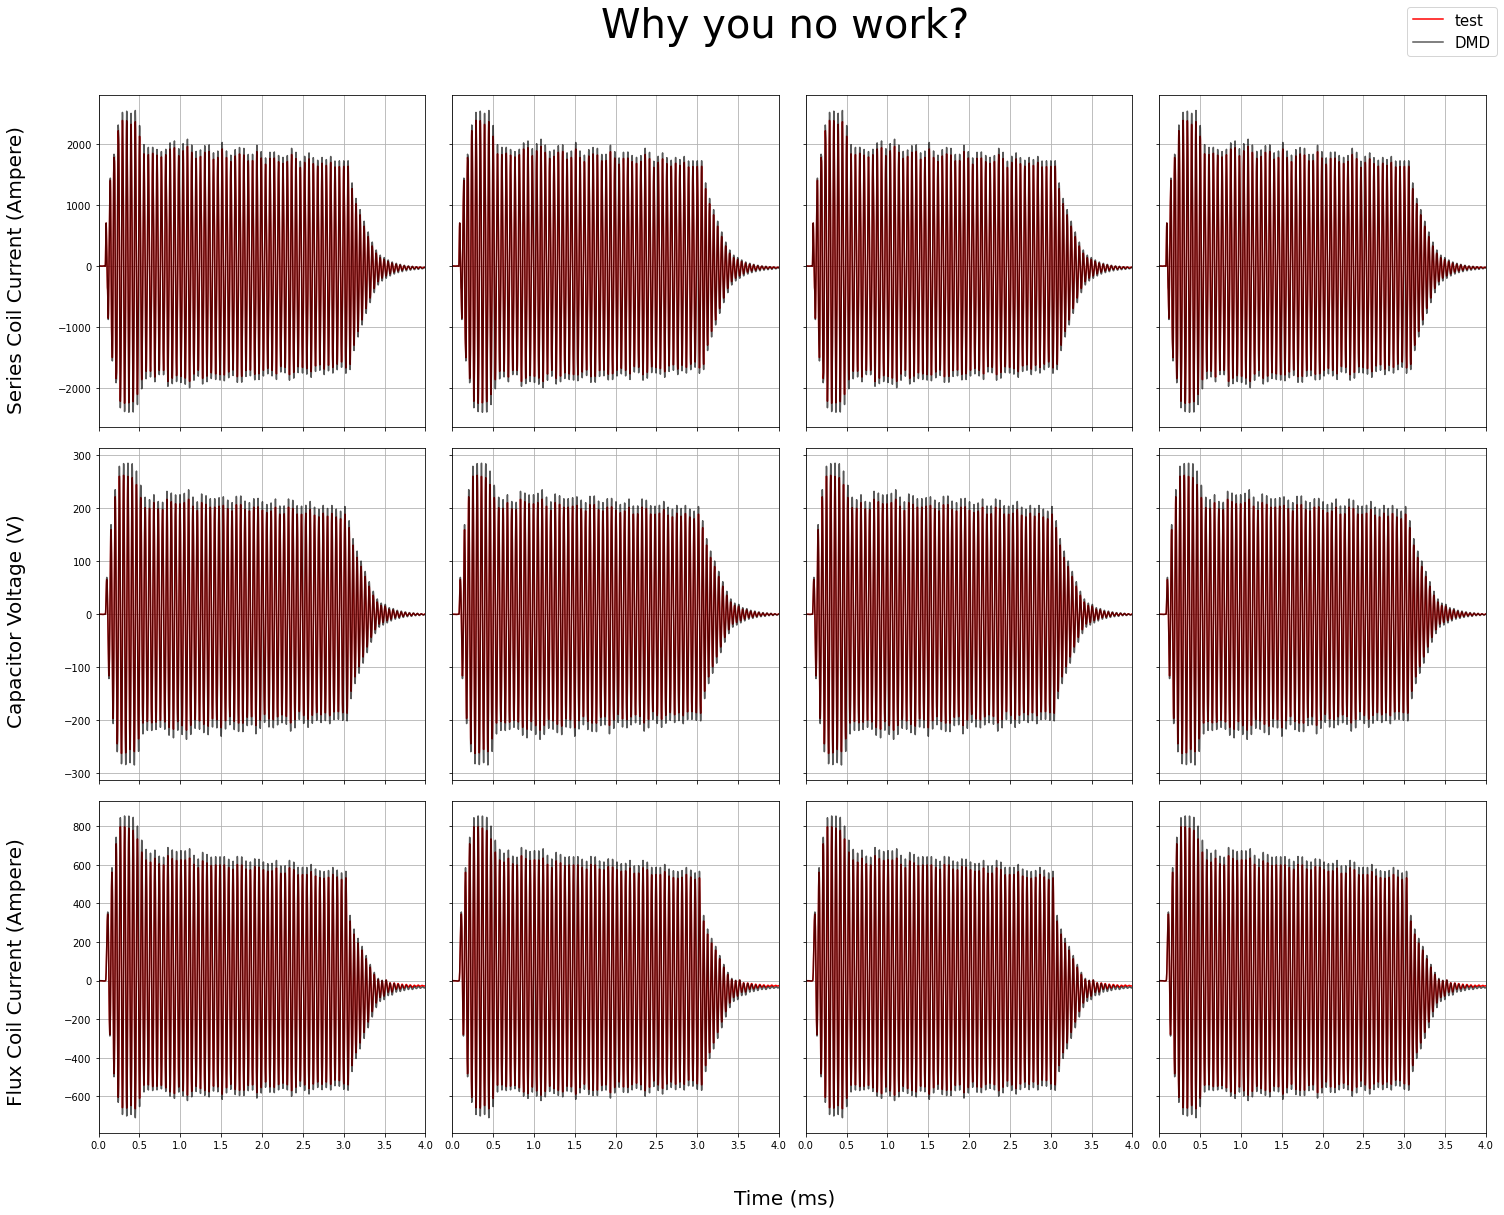

In [60]:
optdmd = BOPDMD(svd_rank=12, num_trials=0)
bopdmd = BOPDMD(svd_rank=3, num_trials=10,compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})

bopdmd.fit(xout_plasma[1521::,0:13].T,experiment_time[1772::])
tout,yout,xout_test = lsim((bopdmd.A,B_plasma,C_plasma,D),inputs_list[2][251::,:],experiment_time[251::])

make_graph([xout_plasma,xout_test],'Why you no work?',['test','DMD'],impulse = False,time = experiment_time[251::])

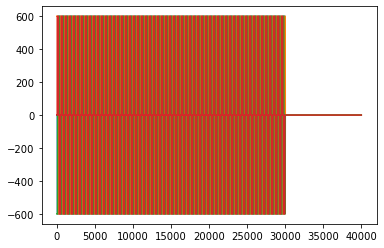

In [73]:
plt.plot(inputs)

In [31]:
# bop_dict = {'matrix':Atilde_vacuum_list[11],'label': 'BOP'}

# dmd_A = savemat('BOP_A_matrix_sim_data.mat',bop_dict)

# print(np.shape(inputs))

# inputs_dict = {'voltages':inputs,'label':'voltage'}

# inputs_savemat = savemat('voltage_inputs.mat',inputs_dict)

(40001, 4)


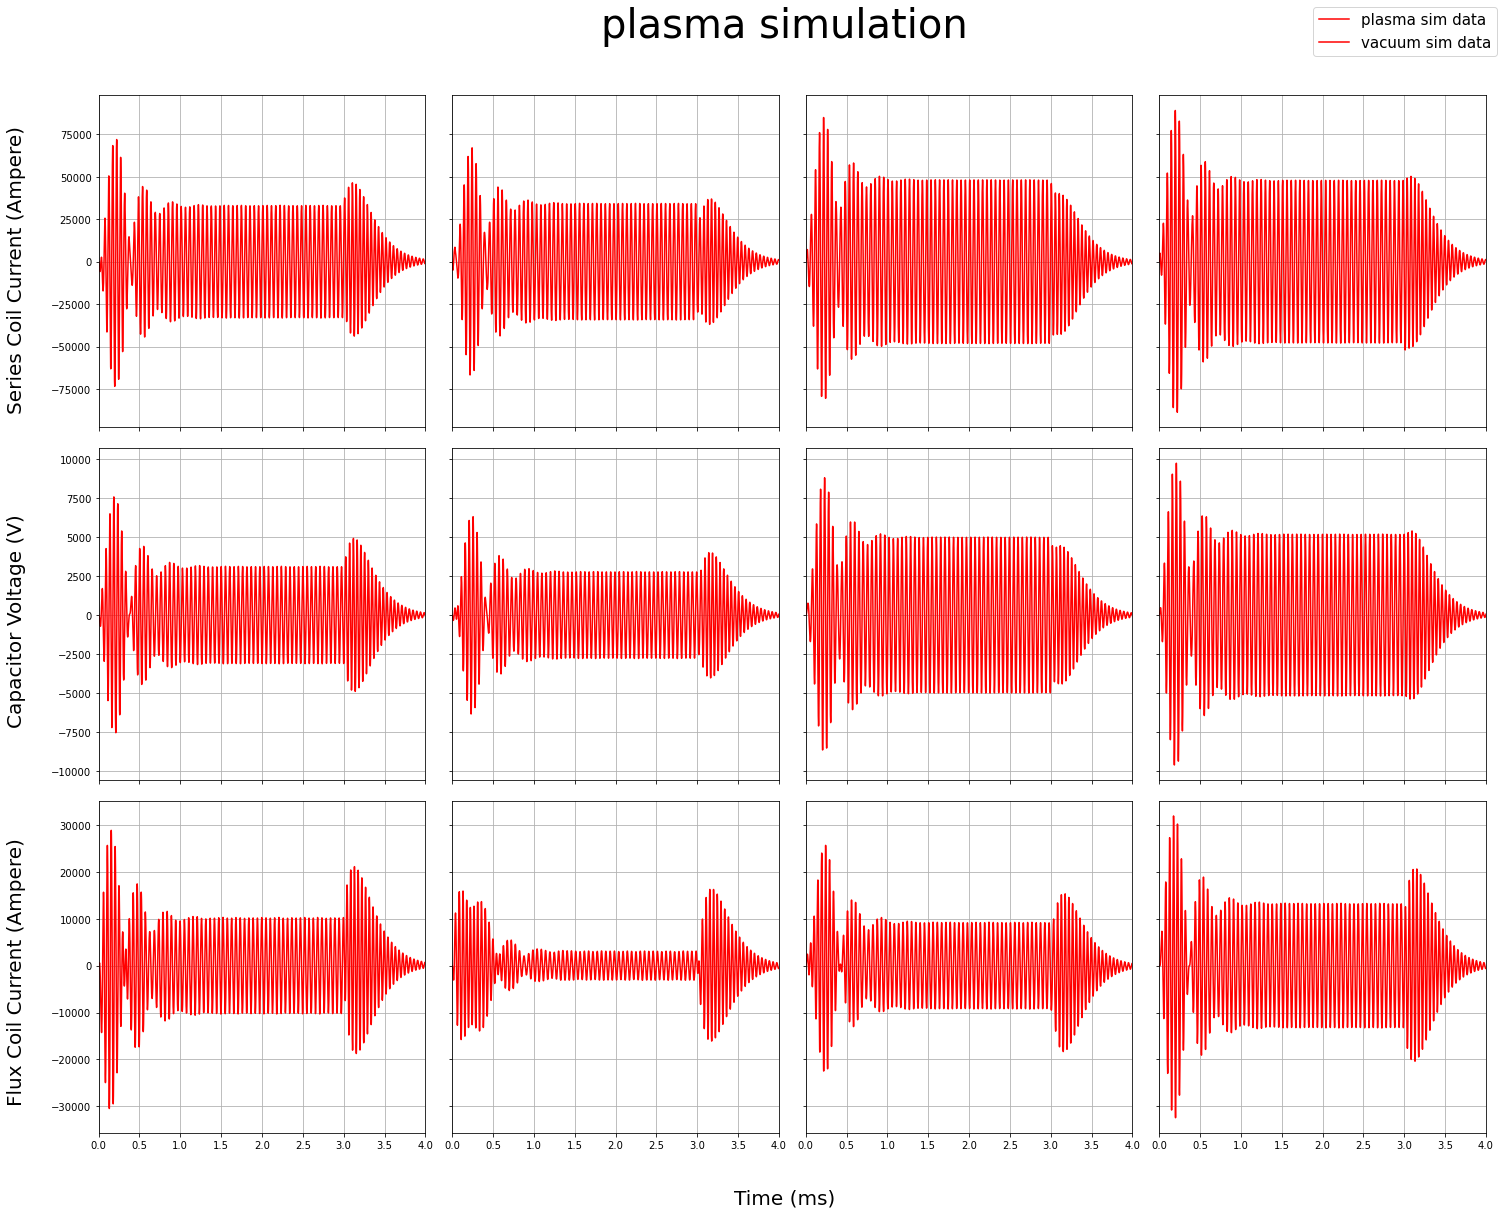

In [42]:
tout,yout,xout_plasma = lsim((A_plasma,B_plasma,C_plasma,D),inputs,time)

make_graph([xout_plasma],'plasma simulation',['plasma sim data','vacuum sim data'],
           impulse = False,time = time)


xout_dict = {'data':xout_plasma,'label': 'data'}
xout_plasma_matlab = savemat('xout_plasma_sim.mat',xout_dict)



In [68]:
Atilde_plasma_list = []
bop_plasma_obj_list = []
xout_plasma_list = []
for i in range(13):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 5,
        training_set = xout_plasma[30000::,0:13].T, #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = inputs[30000::],
        test_voltage = inputs,
        train_time = time[30000::],
        test_time = time, #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_plasma_list.append(Atilde.real)
    bop_plasma_obj_list.append(bop_obj)
    xout_plasma_list.append(xout.real)

13


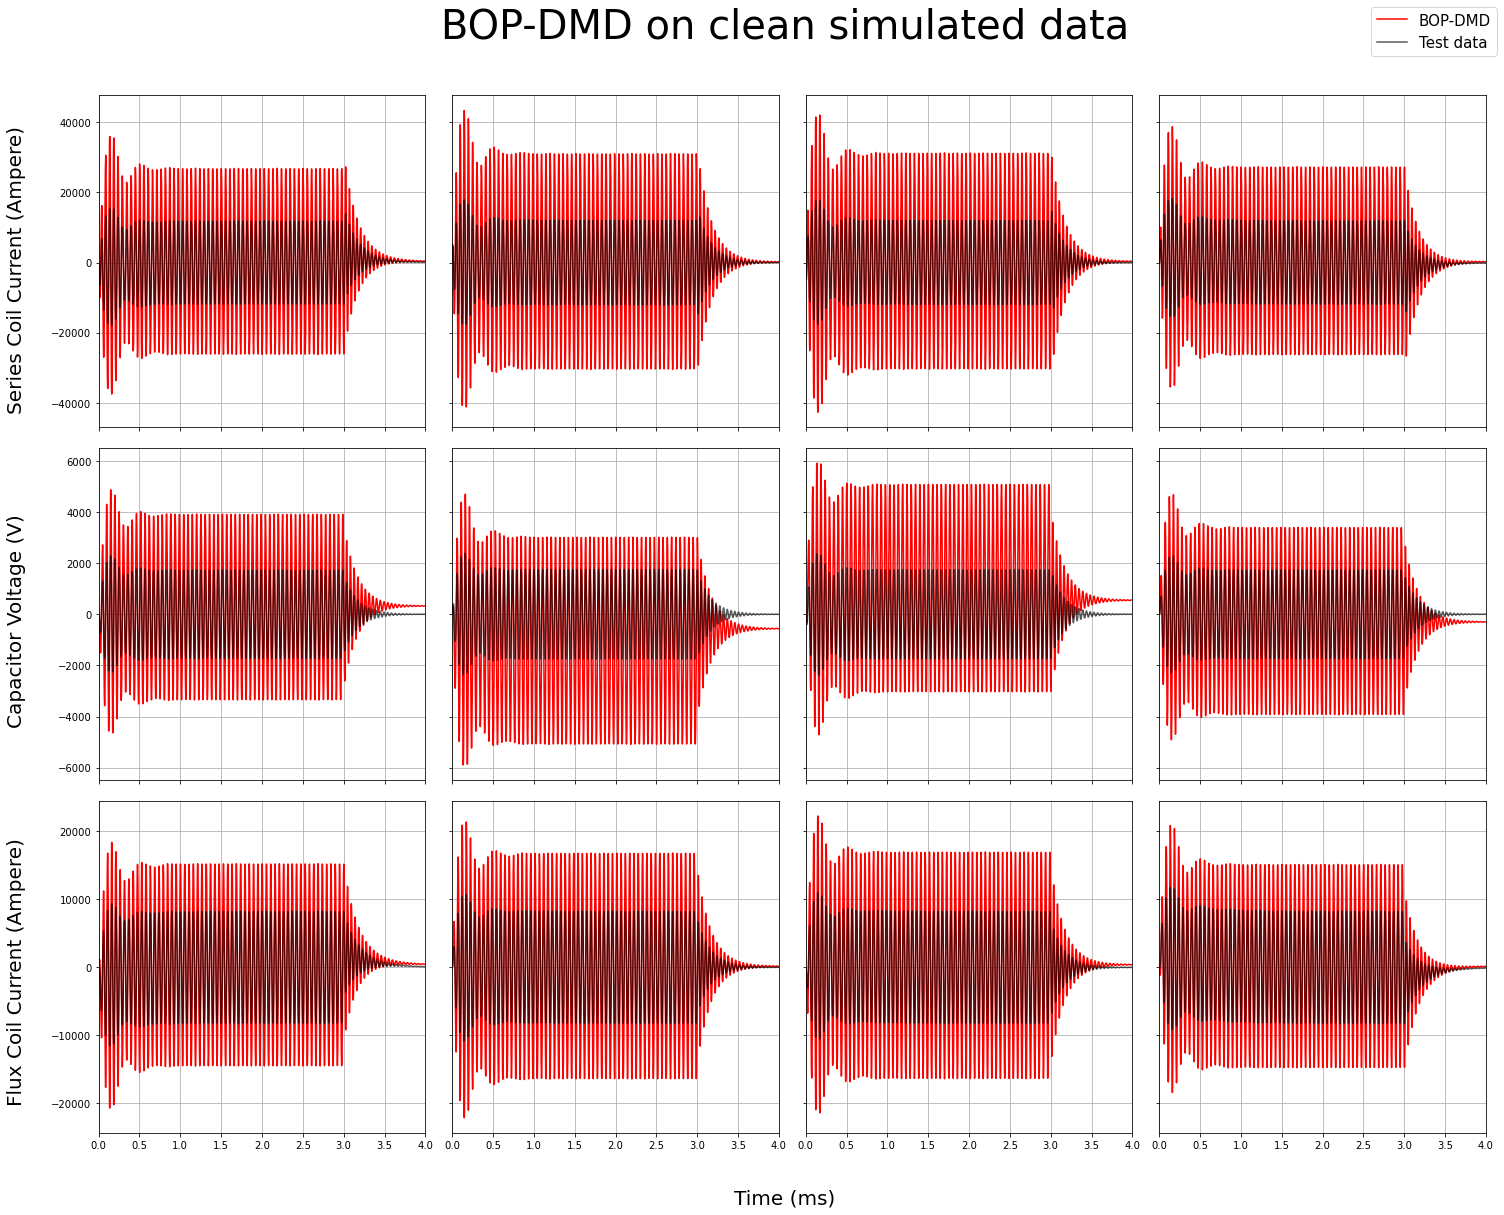

In [67]:
num = 3

print(len(xout_plasma_list))
make_graph([xout_plasma_list[num],xout_plasma],'BOP-DMD on clean simulated data',['BOP-DMD','Test data'],
           impulse = False,time = time)

In [153]:
print(np.linalg.eigvals(Atilde_plasma_list[num]))

[-4.68994109e+05+0.00000000e+00j  4.57939655e+05+0.00000000e+00j
 -1.20842454e+05+0.00000000e+00j  1.11479662e+05+0.00000000e+00j
 -6.42031137e+03+0.00000000e+00j -5.16876951e+03+0.00000000e+00j
 -4.87423746e+03+5.14022671e+02j -4.87423746e+03-5.14022671e+02j
 -4.16825563e+03+0.00000000e+00j -3.01518099e+03+0.00000000e+00j
 -4.68583045e-02+4.61461460e-02j -4.68583045e-02-4.61461460e-02j
  3.91063050e-03+0.00000000e+00j]
